### 진행 순서

- 데이터셋 **로드, 전처리** -> **토큰화** 하기 -> 트랜스포머's **모델 로드**, **훈련**, **추론** -> **모델 평가**
- 🤗데이터셋, 🤗토크나이저, 🤗트랜스포머 라이브러리 이용


### 데이터셋

[🤗데이터셋 docs🤗](https://huggingface.co/docs/datasets/index)

```py
load_dataset("파일 형식(csv,text,json 등..)", data_files="경로")

# ex 예시
load_dataset(
    "csv",
    data_files="file.csv",
    sep=";",
    name=["text","label"])
```

In [40]:
from datasets import load_dataset

dataset = load_dataset("emotion")

In [41]:
dataset # 아파치 애로우 형식 : 하나의 행이 하나의 딕셔너리

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

> 아파치 애로우 형식: 시스템과 프로그래밍 언어 간에 데이터를 효율적으로 교환할 수 있는 컬럼형 인메모리 데이터 형식

In [42]:
dataset['train']['text'][0]

'i didnt feel humiliated'

In [43]:
train_data = dataset['train']

In [44]:
len(train_data), 

(16000,)

### 데이터 셋 to Dataframe

In [45]:
import pandas as pd 

train_data.set_format(type="pandas")
df = train_data[:]

In [46]:
df['label_name'] = df['label'].apply(lambda x: train_data.features["label"].int2str(x))

In [47]:
df

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger
...,...,...,...
15995,i just had a very brief time in the beanbag an...,0,sadness
15996,i am now turning and i feel pathetic that i am...,0,sadness
15997,i feel strong and good overall,1,joy
15998,i feel like this was such a rude comment and i...,3,anger


### **데이터 클래스 분포 확인**

- 데이터 불균형 샘플링 기법
    - [📝내용 설명📝](https://github.com/tommyjin2894/ai_study?tab=readme-ov-file#%EC%83%98%ED%94%8C%EB%A7%81-%EA%B8%B0%EB%B2%95)
    - [🖥️상세 코드🖥️](https://github.com/tommyjin2894/ai_study/blob/main/code/00_basics/09_%EC%83%98%ED%94%8C%EB%A7%81.ipynb) 


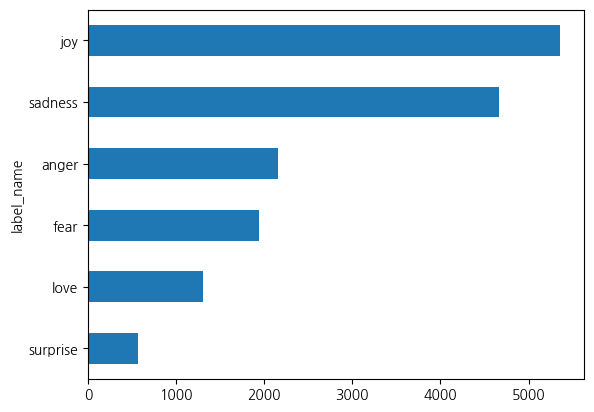

In [48]:
import matplotlib.pyplot as plt

df["label_name"].value_counts(ascending=True).plot.barh();

In [49]:
X = df.drop(columns=["label","label_name"])
y = df["label"]


In [50]:
from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(X,y,
                                                    test_size=0.2,
                                                    random_state=42)

In [51]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import numpy as np

ros = RandomOverSampler(random_state=42)
rus = RandomOverSampler(random_state=42)

x_ros, y_ros = ros.fit_resample(train_x, train_y)
x_rous, y_rous = ros.fit_resample(x_ros, y_ros)

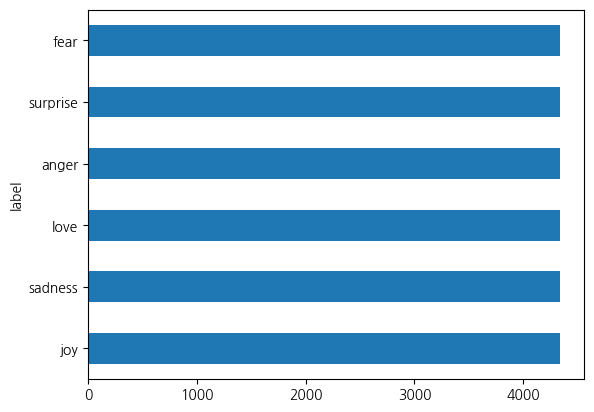

In [52]:
y_rous.apply(lambda x: train_data.features["label"].int2str(x))\
    .value_counts(ascending=True).plot.barh();

### 문장 길이 확인(최대 토큰 길이 측정)
- 간단하게 단어 기준으로 토큰화 진행

In [53]:
df["label_name"].unique()

array(['sadness', 'anger', 'love', 'surprise', 'fear', 'joy'],
      dtype=object)

In [54]:
df['token_length'] = df['text'].str.split(" ").apply(lambda x:len(x))

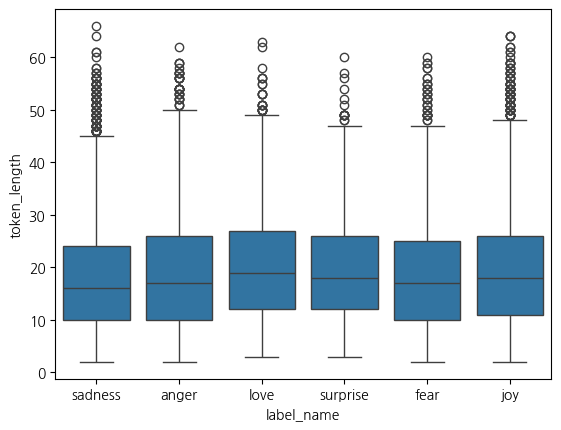

In [55]:
import seaborn as sns

sns.boxplot(data=df,
            x='label_name',
            y='token_length');

### 문장 토큰화 하기

In [56]:
words = set([word for sen in df['text'] for word in sen.split(" ")])
words = sorted(words)
words[1000:2000:100]

['bag',
 'battalion',
 'believers',
 'bikini',
 'blissed',
 'bombsite',
 'braided',
 'bruise',
 'bus',
 'canning']

In [57]:
token2idx = {ch: idx for ch, idx in enumerate(words)}
for i in range(1,16001,1001):
    print(f"index:{i:05}",token2idx[i])

index:00001 aa
index:01002 bagel
index:02003 castiel
index:03004 creates
index:04005 drew
index:05006 figured
index:06007 harder
index:07008 irresponcible
index:08009 machinery
index:09010 nobu
index:10011 plea
index:11012 reminisced
index:12013 shuts
index:13014 sumthg
index:14015 ugg
index:15016 worsen


- 참고) 원핫 인코딩 - to sparse 하다

In [58]:
import torch
import torch.nn.functional as F


for_ohi = torch.tensor(list(token2idx.keys()))

In [59]:
don_ohi = F.one_hot(for_ohi)
don_ohi

tensor([[1, 0, 0,  ..., 0, 0, 0],
        [0, 1, 0,  ..., 0, 0, 0],
        [0, 0, 1,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 1, 0, 0],
        [0, 0, 0,  ..., 0, 1, 0],
        [0, 0, 0,  ..., 0, 0, 1]])

### 부분 단어 토큰화
- 단어 토큰화(5 : "hello", ...) + 문자 토큰화(5 : "h", ...)

- 모델에 맞는 토큰화 방법

In [60]:
from transformers import AutoTokenizer
from transformers import DistilBertTokenizer

model_ckpt="distilbert-base-uncased"
tokenizer_method = AutoTokenizer.from_pretrained(model_ckpt)
tokenizer_method_1 = DistilBertTokenizer.from_pretrained(model_ckpt)

In [61]:
text_str = "Trolling is pretty annoying"

In [62]:
at_token = tokenizer_method(text_str)['input_ids']
print(at_token)

[101, 18792, 2075, 2003, 3492, 15703, 102]


In [63]:
reversed_token = tokenizer_method.convert_ids_to_tokens(at_token)
print(f'{reversed_token}')

['[CLS]', 'troll', '##ing', 'is', 'pretty', 'annoying', '[SEP]']


- [CLS] 문장의 시작,
- [sep] 문장의 분리를 의미,
- `##` 앞 문자열의 공간이 비어있지 않음

In [64]:
tokenizer_method.convert_tokens_to_string(reversed_token)

'[CLS] trolling is pretty annoying [SEP]'

- vocab 크기 확인

In [65]:
print('모델의 vocab 사이즈 :',tokenizer_method.vocab_size)
print('모델의 최대 길이 :',tokenizer_method.model_max_length)
print('모델의 필드 이름 :',tokenizer_method.model_input_names)

모델의 vocab 사이즈 : 30522
모델의 최대 길이 : 512
모델의 필드 이름 : ['input_ids', 'attention_mask']


### 전체 데이터 셋 토큰화

In [66]:
for i in dataset['train'][:3]['text']:
    print(i)

i didnt feel humiliated
i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake
im grabbing a minute to post i feel greedy wrong


In [67]:
tokenize = lambda batch : tokenizer_method([exam for exam in batch['text']],
                                           padding=True, truncation=True)
# test
tokenize(dataset['train'][:2])

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}

In [68]:
# all from datasets

all_datasets_toknized = dataset.map(tokenize, batched=True, batch_size=None)

In [69]:
all_datasets_toknized['train'][:2]

,input_ids,attention_mask
0,"[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0...","[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,"[101, 1045, 2064, 2175, 2013, 3110, 2061, 2062...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


### DistilBERT 훈련하기

- transformers 는 tensorflow, Jax 에서 훈련된 사전 훈련 모델 사용이 가능하다.
    
    ```python
    from transformers import TFAutoModel
    tf_model = TFAutoModel.from_pretrained(model_ckpt, from_pt=True)
    ```
    - Tensorflow의 모델을 불러와 자동으로 변환한다.


In [72]:
model_ckpt

'distilbert-base-uncased'

In [176]:
from transformers import AutoModel

device = torch.device("cuda")
model = AutoModel.from_pretrained(model_ckpt).to(device)

In [180]:
text = "test is fun!"
inputs = tokenizer_method(text, return_tensors='pt') # return_tensors = 옵션 ['pt', 'tf', 'np', 'jax', 'mlx']
inputs={k:v.to(device) for k,v in inputs.items()}
inputs

{'input_ids': tensor([[ 101, 3231, 2003, 4569,  999,  102]], device='cuda:0'),
 'attention_mask': tensor([[1, 1, 1, 1, 1, 1]], device='cuda:0')}

- 필요한 인자 넘겨주기 `input_ids`, `attention_mask`

In [ ]:
with torch.no_grad():
    outputs=model(**inputs)

outputs #named tuple 형태

BaseModelOutput(last_hidden_state=tensor([[[-3.2901e-02, -1.5536e-01,  6.7294e-02,  ..., -3.5374e-02,
           2.2140e-01,  3.0278e-01],
         [ 5.3307e-01, -1.2262e-01,  4.2616e-04,  ..., -3.5551e-01,
           3.7947e-01, -4.7466e-01],
         [-3.0976e-01, -1.6439e-01,  4.3289e-02,  ..., -1.1604e-01,
           1.2671e-01,  4.7686e-01],
         [-9.3830e-03, -1.9277e-01,  2.1580e-01,  ..., -1.1667e-01,
           8.4669e-02,  7.3999e-02],
         [-9.4883e-02, -4.1041e-01,  1.4524e-01,  ...,  2.6162e-01,
           2.6452e-01, -1.3557e-01],
         [ 9.4918e-01,  2.1852e-01, -3.9139e-01,  ...,  2.4219e-01,
          -4.7567e-01, -3.0236e-01]]], device='cuda:0'), hidden_states=None, attentions=None)

### [distilBERT](https://arxiv.org/pdf/1910.01108)
- BERT 대비 40% 작은 모델
- 언어 이해 능력의 97% 유지
- 60% 빠른 속도
- triple loss method:
    - loss combining language modeling,
    - distillation
    - cosine-distance losses

- 참고
    - [Knowledge Distilling](https://arxiv.org/pdf/1503.02531)
    - Task-specific distillation
    - [Multi-distillation](https://arxiv.org/pdf/2210.16103)

In [213]:
outputs.last_hidden_state.shape

torch.Size([1, 6, 768])

- 1 배치, 6 토큰, 768 차원의 임베딩 벡터

In [ ]:
#각 6개의 토큰마다 768 차원의 임베딩 벡터
tokenizer_method.convert_ids_to_tokens(inputs['input_ids'][0])

['[CLS]', 'test', 'is', 'fun', '!', '[SEP]']

In [214]:
def extract_hidden_states(batch):
    inputs = {k:v for k,v in batch.items()}
    return inputs

extract_hidden_states(outputs)

{'last_hidden_state': tensor([[[-3.2901e-02, -1.5536e-01,  6.7294e-02,  ..., -3.5374e-02,
            2.2140e-01,  3.0278e-01],
          [ 5.3307e-01, -1.2262e-01,  4.2616e-04,  ..., -3.5551e-01,
            3.7947e-01, -4.7466e-01],
          [-3.0976e-01, -1.6439e-01,  4.3289e-02,  ..., -1.1604e-01,
            1.2671e-01,  4.7686e-01],
          [-9.3830e-03, -1.9277e-01,  2.1580e-01,  ..., -1.1667e-01,
            8.4669e-02,  7.3999e-02],
          [-9.4883e-02, -4.1041e-01,  1.4524e-01,  ...,  2.6162e-01,
            2.6452e-01, -1.3557e-01],
          [ 9.4918e-01,  2.1852e-01, -3.9139e-01,  ...,  2.4219e-01,
           -4.7567e-01, -3.0236e-01]]], device='cuda:0')}

In [219]:
all_datasets_toknized.items()

dict_items([('train', Dataset({
    features: ['input_ids', 'attention_mask'],
    num_rows: 16000
})), ('validation', Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 2000
})), ('test', Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 2000
}))])